In [1]:
import pandas as pd
from Functions import clean_split
# pd.options.display.max_rows = 35 
# pd.options.display.max_columns = 

In c:\users\heeeb\anaconda3\envs\codeacademy\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\heeeb\anaconda3\envs\codeacademy\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\heeeb\anaconda3\envs\codeacademy\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\heeeb\anaconda3\envs\codeacademy\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\heeeb\anacon

In [2]:
df = pd.read_csv('data/TweetsOriginal.csv', encoding = 'ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import nltk 
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords, words, names
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.utils import resample
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.cluster import KMeans


def plot_model_results(results, model_names, filepath, figure_title, figsize = (10, 8)):
    
    """Plots and saves an image of the plot.
    Input:
    results: the results of the models, gained from test_models()
    model_names: the names of models used, gained from test_models()
    filepath: the filepath for the graph image to be saved to
    """
    
    plt.figure(figsize = figsize)
    plt.boxplot(results, labels = model_names, showmeans = True)
    plt.title(f'{figure_title}')
    plt.ylabel('Accuracy'); plt.xlabel('Model')
    plt.savefig(filepath)
    plt.show()

def test_models(x_train, y_train, models, n_jobs = 2):
    """
    Test all models given.
    
    This will test each model on its own using RepeatedStratifiedKFold then it will test a stacking classifier with every single model in the dictionary.  
    
    returns: vanilla_dict (contains results and model names)"""
    results = []
    model_names = []
    pbar = tqdm(models.items())
    
    for model, m in pbar: 
        pbar.set_description(f'Evaluating {model.upper()}')
        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)
        scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = n_jobs, 
                                 error_score = 'raise')
        results.append(scores)
        model_names.append(model)
    vanilla_dict = {i:y for i,y in zip(model_names, results)}
   
    return vanilla_dict


def stacked_model(models):
    """Creates a stacked model given a dictionary of SciKitLearn models
    -----------------------------------------
    Input: 
        models: Dictionary containing the model name and function.
    
    Output: 
        stack_model: A new dictionary containing a SciKitLearn StackingClassifier object
    -----------------------------------------"""

    stack_m = [] 
    for model, m in models.items(): 
        stack_m.append((model, m))
    stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 3)
    models['stacked'] = stack_model
    
    return models


def save_cv_results(model_dict, filename):
    """
    Pickles the model's results
    
    Input: 
    
    model_names: list of model names 
    results: list of results 
    filename: str, path for the file to be saved
    
    """
    pickle.dump(model_dict, open(filename, 'wb'))
    return 'Done'


def import_tweet_data():
    """Imports the tweet data from the 'data' folder, 
    with ISO-8859-1 encoding.
    
    Output: A Pandas DataFrame"""
    
    df = pd.read_csv('data/TweetsOriginal.csv', encoding = 'ISO-8859-1' )
    return df
    

def run_gridsearch(classifier, X_train, y_train, X_test, y_test, params, n_jobs = 2, verbose = 0):
    
    """A function for performing a grid search using a random forest model.
    Uses the training data and outputs the scores for the train and test data.
    
    Input: 
    
    classifier: classifier object
    X_train: The training features of the dataset
    y_train: The training class for the dataset
    X_test: The test features of the dataset
    y_test: The test classes of the dataset
   
    params: The parameters for classifier grid search
    n_jobs: n_jobs
    verbose: verbose
    
    Output:
    
    forest_clf: The Grid Search object
    """
    
    clf = GridSearchCV(
        estimator = classifier,
        param_grid = params,
        n_jobs = n_jobs,
        verbose = verbose, error_score = 0.0
    )
    
    clf.fit(X_train, y_train)
    
    print(f"""       Results
~~~~~~~~~~~~~~~~~~~~~
Train Score: {clf.score(X_train, y_train):.2f}
---
Test Score: {clf.score(X_test, y_test):.2f}
Best Parameters:
{clf.best_params_}
""")
    
    return clf



def clean_split(df): 
    '''This function takes in the original tweet dataframe and does the following
    
    1. Change column names
    2. Removes NA values within the columns Tweet and Emotion 
    3. Removes unwanted characters ($,@,#, etc.) 
    4. Applies a stemming technique to normalize the words
    5. Applies a count vectorizer on the train data 
    6. Save the count vectorizer as a pickle so that it can be used to transform new data 
    7. Save the train and test df to csv for visualizations
    8. Resample the train and test so the targets are balanced
    9. return x_train, x_test, y_train, y_test'''
    
    new_df = df
    
    new_df.rename(columns = {
        'tweet_text': 'Text', 
         'emotion_in_tweet_is_directed_at' : 'Item', 
        'is_there_an_emotion_directed_at_a_brand_or_product' : 'Emotion'
    }, inplace = True)
    
    new_df['Emotion_New'] = new_df.Emotion.replace(to_replace = {
        'Negative emotion' : 0,
        'Positive emotion' : 1,
        'No emotion toward brand or product': None,
        "I can't tell" : None
    }
    )
    
    #dropping na in columns Text and Emotion
    new_df.dropna(subset = ['Text', 'Emotion_New'], inplace = True)
 

    eng_words = set(words.words())
    eng_names = [i[0] for i in names.words('male.txt')] + [i[0] for i in names.words('female.txt')]
 
    tweets = new_df.Text.values
    new_tweets = []
    for sent in tweets:
        new_tweets.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sent.lower()).split()))
    new_df.Text = new_tweets
    
    #removes unwanted characters
    word_tokenizer = RegexpTokenizer("([a-zA-Z&]+(?:'[a-z]+)?)")
    word_stem = PorterStemmer()
    new_df.Text= new_df.Text.map(lambda x: word_tokenizer.tokenize(x.lower()))
    #includes only stemmed words
    new_df.Text = new_df.Text.map(lambda x: ' '.join([word_stem.stem(i) for i in x if len(i) > 2 and i not in eng_names]))

    
    print('Original Value Counts')
    print(new_df.Emotion_New.value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    pos_df = new_df[new_df.Emotion_New == 1]
    neg_df = new_df[new_df.Emotion_New == 0]

    #resample data based on target
    resample_pos = resample(pos_df, n_samples = 600, random_state = 10, replace = False)
    new_df = resample_pos.append(neg_df, ignore_index = True)
    print('Final Resampled Value Counts')
    print(new_df.Emotion_New.value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
   
    #split into test and trains
    x_train, x_test, y_train, y_test = train_test_split(new_df[['Item', 'Text']], new_df.Emotion_New, stratify = new_df.Emotion_New,                     
                                                        train_size = .85, random_state = 10)
    #removing stop words
    new_stop = ['abacus', 'yr', 'acerbic', 'bcet', 'beechwood', 'bicycle', 'brian', 'ce', 'mngr', 
               'rewardswagon', 'loui', 'csuitecsourc', 'wjchat', 'peter', 'bbq', 'au',  'awesometim', 'bankinnov', 
                'barton', 'boooo', 'bookbook', 'zzz', 'william', 'tomlinson', 'orlando', 'oo', 'yeaayyy', 'thursday', 'monday', 
               'friday', 'fri', 'saturday', 'sunday', 'tuesday', 'austin']
    stop = stopwords.words('english') + new_stop
    vectorizer= CountVectorizer(stop_words = stop, max_features = 6000, ngram_range=(1,1), min_df = 3)
   
    #creates a test and train df for visualization
    clean_train = x_train.Text.values
    train_items = x_train.Item.values
    clean_test = x_test.Text.values
    test_items = x_test.Item.values
    vectorizer.fit(clean_train)
 
    #saves vectorizer as a pickle for future use
    pickle.dump(vectorizer, open('../Pickles/vectorizer.p', 'wb'))

    train_features =vectorizer.transform(clean_train).toarray()
    test_features = vectorizer.transform(clean_test).toarray()
    
       
    kmeans = KMeans(n_clusters = 6)
    kmeans.fit(train_features)
    train_clusters = kmeans.predict(train_features)
    test_clusters = kmeans.predict(test_features)
    
    train_df = pd.DataFrame(train_features, columns = vectorizer.get_feature_names())
    train_df['target'] = y_train.values
    train_df['Item'] = train_items
    train_df['Cluster'] = train_clusters
    
    test_df = pd.DataFrame(test_features, columns = vectorizer.get_feature_names())
    test_df['target'] = y_test.values
    test_df['Item'] = test_items
    test_df['Cluster'] = test_clusters
    
    #saves test and train df for visualizations
    train_df.to_csv('data/TrainDF.csv', index = False)
    test_df.to_csv('data/TestDF.csv', index = False)
    
    x_train = train_df[[i for i in train_df.columns if i not in ['target', 'Item']]].values
    y_train = train_df[['target']].values.ravel()
    
    x_test = test_df[[i for i in test_df.columns if i not in ['target', 'Item']]].values
    y_test = test_df[['target']].values.ravel()
    
    return x_train, x_test, y_train, y_test

In [4]:
x_train, x_test, y_train, y_test = clean_split(df)

Original Value Counts
1.0    2978
0.0     570
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Final Resampled Value Counts
1.0    600
0.0    570
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Vanilla Train: 0.9255533199195171
Vanilla Test: 0.8011363636363636
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Vanilla Train: 0.9647887323943662
Vanilla Test: 0.8011363636363636
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


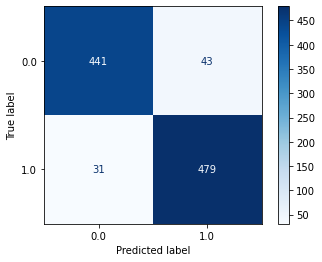

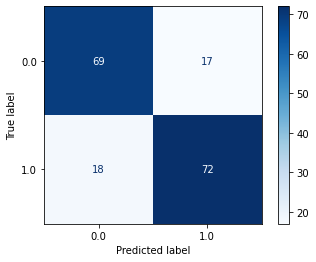

In [5]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression 

log = LogisticRegression()
log.fit(x_train, y_train) 

print(f'Vanilla Train: {log.score(x_train, y_train)}')
print(f'Vanilla Test: {log.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')



ridge = RidgeClassifier(random_state = 10)
ridge.fit(x_train, y_train) 

print(f'Vanilla Train: {ridge.score(x_train, y_train)}')
print(f'Vanilla Test: {ridge.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log, x_train, y_train, cmap = 'Blues')
plot_confusion_matrix(log, x_test, y_test, cmap = 'Blues')

In [6]:
assert False

AssertionError: 

In [ ]:
ssd = clean_split(df)

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(range(2,10), ssd, 'bx-')
plt.xlabel('KMeans Clusters')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.vlines(6, min(ssd), max(ssd), linestyles = '--')
plt.savefig('figures/KMeans.png')
plt.show()

In [ ]:
assert False

In [ ]:
x_train, x_test, y_train, y_test = clean_split(df)
test_df = pd.read_csv('data/TrainDF.csv')
columns = test_df.columns.tolist()
sum_values = test_df.sum() 

for c, s in zip(columns, sum_values): 
    print(c, s)

In [ ]:
['abacus', 'yr', 'acerbic', 'bcet', 'beechwood', 'bicycle', 'brian', 'sxsw', 'ce', 'louis', 'mngr', 
               'rewardswagon', 'loui', 'csuitecsourc', 'wjchat', 'peter', 'bbq', 'au', 'austin', 'awesometim', 'bankinnov', 
                'barton', 'boooo', 'bookbook', 'zappo', 'zazzlesxsw', 'gswsxsw', 'tmsxsw', 'ye', 
                'xipad', 'xooom', 'agileag', 'whrrl', 'whi', 'marissamey', 'evolvingworkplac', 'fastsocieti', 'foursquar',
                'justin', 'frankeninterfac', 'gowalla']

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression, RidgeClassifier

x_train, x_test, y_train, y_test, test_df = clean_split(2, df)

log = LogisticRegression()
log.fit(x_train, y_train) 

print(f'Vanilla Train: {log.score(x_train, y_train)}')
print(f'Vanilla Test: {log.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')



ridge = RidgeClassifier(random_state = 10)
ridge.fit(x_train, y_train) 

print(f'Vanilla Train: {ridge.score(x_train, y_train)}')
print(f'Vanilla Test: {ridge.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


rf = RandomForestClassifier(random_state = 10, n_jobs = -1)
rf.fit(x_train, y_train) 

print(f'Vanilla Train: {rf.score(x_train, y_train)}')
print(f'Vanilla Test: {rf.score(x_test, y_test)}')

In [ ]:
columns = test_df.columns.tolist()
sum_values = test_df.sum() 

for c, s in zip(columns, sum_values): 
    print(c, s)
    # for c, s in enum_sum: 
#     print(c, s)

In [ ]:
'dst', 'amp', 'farm', 'fmsignal', 'sxswi'

In [ ]:
rf_pickle = pickle.load(open('../Pickles/Forest_6_clf.p', 'rb'))
rf_pickle

In [ ]:
rf_pickle.best_estimator_

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=2,
                       oob_score=True, random_state=10)

rf.fit(x_train, y_train)
print(rf.score(x_train, y_train), rf.score(x_test, y_test))